In [1]:
import javabridge
import os
import glob
import pandas as pd
import pydot
from IPython.display import SVG

In [2]:
tetrad_libdir = os.path.join(os.getcwd(), '../../','src', 'pycausal', 'lib')
for l in glob.glob(tetrad_libdir + os.sep + "*.jar"):
    print(l)
    javabridge.JARS.append(str(l))

/home/jovyan/py-causal/example/javabridge/../../src/pycausal/lib/tetrad-lib-6.4.0-SNAPSHOT-tetradcmd.jar
/home/jovyan/py-causal/example/javabridge/../../src/pycausal/lib/data-reader-0.2.3-SNAPSHOT.jar


In [3]:
javabridge.start_vm(run_headless=True, max_heap_size = '1000M')
javabridge.attach()

In [4]:
data_dir = os.path.join(os.getcwd(), '../../','data', 'sim_discrete_data_20vars_100cases.txt')
data_dir

'/home/jovyan/py-causal/example/javabridge/../../data/sim_discrete_data_20vars_100cases.txt'

In [5]:
dframe = pd.read_table(data_dir, sep="\t")
dframe.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19
0,1,0,0,1,0,2,2,0,1,1,2,2,1,0,1,0,0,1,1,2
1,2,0,2,1,0,2,1,0,2,0,2,2,0,1,2,0,0,1,2,1
2,2,0,0,1,0,0,2,0,1,1,2,2,0,1,1,2,0,0,1,0
3,2,0,0,0,0,1,2,2,2,2,2,2,2,0,2,0,1,0,1,0
4,1,0,2,0,0,0,0,2,2,2,2,2,1,2,2,0,1,1,1,1


In [6]:
dataBox = javabridge.JClassWrapper("edu.cmu.tetrad.data.VerticalIntDataBox")(len(dframe.index),dframe.columns.size)

In [7]:
node_list = javabridge.JClassWrapper("java.util.ArrayList")()
# load dataset
col_no = 0
for col in dframe.columns:
    
    cat_array = sorted(set(dframe[col]))
    cat_list = javabridge.JClassWrapper("java.util.ArrayList")()
    
    for cat in cat_array:
        cat = str(cat)
        cat_list.add(cat)
        
    nodi = javabridge.JClassWrapper("edu.cmu.tetrad.data.DiscreteVariable")(col, cat_list)
    node_list.add(nodi)
    
    for row in dframe.index:
        value = javabridge.JClassWrapper("java.lang.Integer") (cat_array.index(dframe.iloc[row,col_no]))
        dataBox.set(row,col_no,value)
    
    col_no = col_no + 1

In [8]:
boxData = javabridge.JClassWrapper("edu.cmu.tetrad.data.BoxDataSet")(dataBox, node_list)

In [9]:
alpha = 0.05
IndTest = javabridge.JClassWrapper('edu.cmu.tetrad.search.IndTestChiSquare')(boxData, alpha)

In [10]:
cpc = javabridge.JClassWrapper('edu.cmu.tetrad.search.Cpc')(IndTest)

In [11]:
cpc.setDepth(-1)
cpc.setVerbose(True)

In [12]:
tetradGraph = cpc.search()
tetradGraph

Instance of edu.cmu.tetrad.graph.EdgeListGraph: Graph Nodes:
X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19

Graph Edges:
1. X10 --- X17
2. X11 --- X14
3. X12 --- X15
4. X14 --- X18
5. X15 --> X19
6. X17 --> X19
7. X3 --> X7
8. X3 --- X9
9. X4 --- X10
10. X4 --- X11
11. X4 --- X8
12. X6 --- X13
13. X6 --> X7
14. X7 --- X13


Ambiguous triples (i.e. list of triples for which there is ambiguous data about whether they are colliders or not):
<X10, X4, X8>
<X4, X11, X14>
<X3, X7, X13>
<X17, X10, X4>
<X18, X14, X11>
<X10, X4, X11>
<X8, X4, X11>

In [13]:
dags = javabridge.JClassWrapper('edu.cmu.tetrad.search.DagInPatternIterator')(tetradGraph)
dagGraph = dags.next()
dag = javabridge.JClassWrapper('edu.cmu.tetrad.graph.Dag')(dagGraph)
dag

Instance of edu.cmu.tetrad.graph.Dag: Graph Nodes:
X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19

Graph Edges:
1. X10 --> X4
2. X11 --> X4
3. X13 --> X6
4. X13 --> X7
5. X14 --> X11
6. X15 --> X12
7. X15 --> X19
8. X17 --> X10
9. X17 --> X19
10. X18 --> X14
11. X3 --> X7
12. X6 --> X7
13. X8 --> X4
14. X9 --> X3

In [14]:
graph = pydot.Dot(graph_type='digraph')
n = dag.getNodes().toString()
n = n[1:len(n)-1]
n = n.split(",")
nodes = []
for i in range(0,len(n)):
    node = n[i]
    n[i] = node.strip()
    nodes.append(pydot.Node(n[i]))
    graph.add_node(nodes[i])

In [15]:
def isNodeExisting(nodes,node):
    try:
        nodes.index(node)
        return True
    except IndexError:
        print ("Node {} does not exist!".format(node))
        return False

e = tetradGraph.getEdges().toString()
e = e[1:len(e)-1]
e = e.split(",")
for i in range(0,len(e)):
    e[i] = e[i].strip()
    token = e[i].split(" ")
    if(len(token) == 3):
        src = token[0]
        arc = token[1]
        dst = token[2]
        if(isNodeExisting(n,src) and isNodeExisting(n,dst)):
            edge = pydot.Edge(nodes[n.index(src)],nodes[n.index(dst)])
            
            if(arc[0] != "-"):
                edge.set_dir("both")
            
            if(arc[0] == "o"):
                edge.set_arrowtail("odot")
            elif(arc[0] == "<"):
                edge.set_arrowtail("normal")
            
            if(arc[2] == "-"):
                edge.set_arrowhead("none")
            elif(arc[2] == "o"):
                edge.set_arrowhead("odot")
            else:
                edge.set_arrowhead("normal")
            
            graph.add_edge(edge)

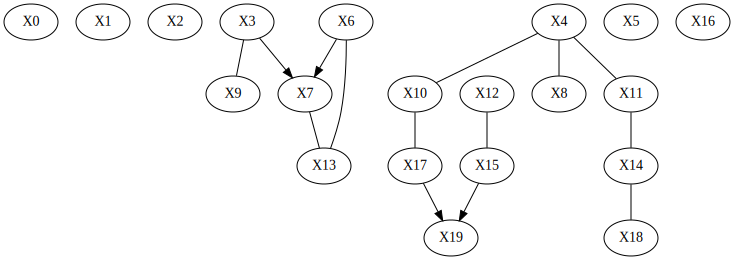

In [16]:
svg_str = graph.create_svg(prog='dot')
SVG(svg_str)

In [17]:
pm = javabridge.JClassWrapper('edu.cmu.tetrad.bayes.BayesPm')(dag)
pm

Instance of edu.cmu.tetrad.bayes.BayesPm: 
X1: 0, 1, 2
X5: 0, 1, 2
X6: 0, 1, 2
X15: 0, 1, 2
X0: 0, 1, 2
X11: 0, 1, 2
X7: 0, 1, 2
X9: 0, 1, 2
X14: 0, 1, 2
X2: 0, 1, 2
X4: 0, 1, 2
X8: 0, 1, 2
X12: 0, 1, 2
X18: 0, 1, 2
X16: 0, 1, 2
X13: 0, 1, 2
X17: 0, 1, 2
X3: 0, 1, 2
X19: 0, 1, 2
X10: 0, 1, 2

In [18]:
est = javabridge.JClassWrapper('edu.cmu.tetrad.bayes.MlBayesEstimator')()
im = est.estimate(pm, boxData)
im = im.toString()
im

'\n\nNode: X0\n\n0.0900\t0.1700\t0.7400\t\n\nNode: X1\n\n0.9400\t0.0500\t0.0100\t\n\nNode: X2\n\n0.7800\t0.0900\t0.1300\t\n\nNode: X3\n\nX9\t\n0\t0.0000\t0.3077\t0.6923\t\n1\t0.1111\t0.8148\t0.0741\t\n2\t0.8235\t0.1176\t0.0588\t\n\nNode: X4\n\nX8\tX10\tX11\t\n0\t0\t0\t�\t�\t�\t\n0\t0\t1\t�\t�\t�\t\n0\t0\t2\t�\t�\t�\t\n0\t1\t0\t�\t�\t�\t\n0\t1\t1\t�\t�\t�\t\n0\t1\t2\t�\t�\t�\t\n0\t2\t0\t�\t�\t�\t\n0\t2\t1\t�\t�\t�\t\n0\t2\t2\t0.0000\t1.0000\t0.0000\t\n1\t0\t0\t1.0000\t0.0000\t0.0000\t\n1\t0\t1\t0.3333\t0.3333\t0.3333\t\n1\t0\t2\t1.0000\t0.0000\t0.0000\t\n1\t1\t0\t�\t�\t�\t\n1\t1\t1\t0.0000\t0.0000\t1.0000\t\n1\t1\t2\t0.2500\t0.2500\t0.5000\t\n1\t2\t0\t1.0000\t0.0000\t0.0000\t\n1\t2\t1\t1.0000\t0.0000\t0.0000\t\n1\t2\t2\t1.0000\t0.0000\t0.0000\t\n2\t0\t0\t�\t�\t�\t\n2\t0\t1\t�\t�\t�\t\n2\t0\t2\t0.8000\t0.2000\t0.0000\t\n2\t1\t0\t0.5000\t0.2500\t0.2500\t\n2\t1\t1\t�\t�\t�\t\n2\t1\t2\t0.3333\t0.2222\t0.4444\t\n2\t2\t0\t1.0000\t0.0000\t0.0000\t\n2\t2\t1\t0.0000\t1.0000\t0.0000\t\n2\t2\t2\t0

In [19]:
javabridge.detach()
javabridge.kill_vm()